In [1]:
import numpy as np
import cv2 as cv
from cake import cake
from matplotlib import pyplot as plt
from scipy import signal
from scipy.spatial.transform import Rotation as R
from scipy.linalg import lstsq
from cluster_to_edge_pixel import cluster_to_edge

In [2]:
start_frame=0
end_frame=999
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
obj_0=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
obj_0=obj_0[1:,:]

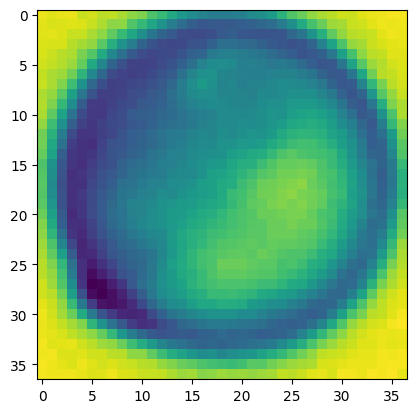

In [3]:
#frame_number=523
#frame_number=10
frame_number=257
index_number=round(frame_number-obj_0[0,0])
obj_image_current=cv.imread(cv.samples.findFile(stream_string[frame_number]), cv.IMREAD_GRAYSCALE)
object_indeces=np.s_[round(obj_0[index_number,2]-np.ceil(obj_0[index_number,3])):round(obj_0[index_number,2]+np.ceil(obj_0[index_number,3]))+1,
                     round(obj_0[index_number,1]-np.ceil(obj_0[index_number,3])):round(obj_0[index_number,1]+np.ceil(obj_0[index_number,3]))+1]
obj_image_current=obj_image_current[object_indeces]

plt.figure()
plt.imshow(obj_image_current)
plt.show()

# Cut Border of Circle for 2 means clustering

(37, 37)
(317,)


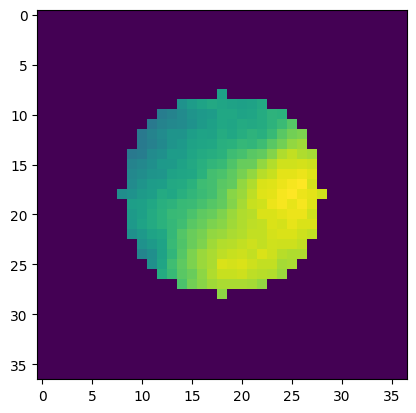

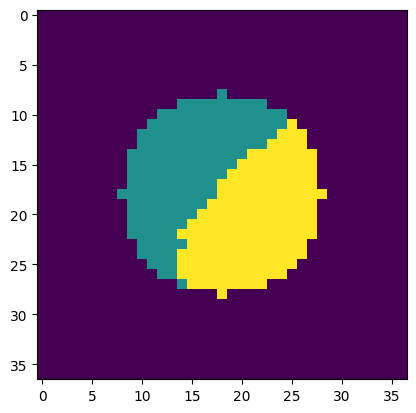

In [4]:
image_shape=obj_image_current.shape
cut_radius=round(obj_0[index_number,-1]*0.6)
M=cake(cut_radius)
pad_length=(obj_image_current.shape[0]-M.shape[0])//2
M=np.pad(M, pad_width=[(pad_length,pad_length),(pad_length,pad_length)], mode='constant')

object_pixels=np.copy(obj_image_current)
object_pixels=np.float32(object_pixels[M==1])
print((M==1).shape)
print(object_pixels.shape)
attempts=10
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv.kmeans(object_pixels, 2, None, criteria, attempts, cv.KMEANS_RANDOM_CENTERS)

label=label+1
object_clustered=np.zeros(image_shape,np.uint8)
object_clustered[M==1]=label.reshape(-1)

obj_image_current[M==0]=0
plt.figure()
plt.imshow(obj_image_current)
plt.show()
plt.figure()
plt.imshow(object_clustered)
plt.show()



# Try Different Filter for Edges

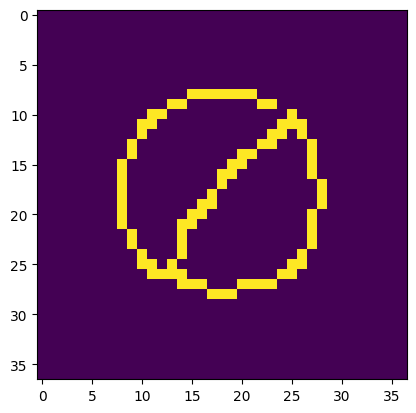

In [5]:
object_clustered=np.float32(object_clustered)
#object_clustered=object_clustered-1
#object_clustered[object_clustered<0]=0

object_clustered_uint8=np.copy(np.uint8(object_clustered*255//2))
edges = cv.Canny(image=object_clustered_uint8, threshold1=100, threshold2=200) # Canny Edge Detection
plt.figure()
plt.imshow(edges)
plt.show()

edge_pixels=np.where(edges==255)
edge_pixels=np.concatenate((edge_pixels[0].reshape(-1,1),edge_pixels[1].reshape(-1,1)),axis=1)


# Try Edge filter with horizontal, vertical and diagonal filter

In [6]:
horizontal_heaviside=np.array([[1,-1]])
vertical_heaviside=np.array([[1],[-1]])
diagonal_heaviside=np.zeros((2,2))
diagonal_heaviside[0,0]=1
diagonal_heaviside[1,1]=-1
print(horizontal_heaviside,vertical_heaviside,diagonal_heaviside)
A=np.arange(9).reshape((3,3))
print(A)
B=signal.convolve2d(A, horizontal_heaviside, mode='valid')
B=np.pad(B, pad_width=[(0,0),(1,0)], mode='constant')
print(B)
B=signal.convolve2d(A, vertical_heaviside, mode='valid')
B=np.pad(B, pad_width=[(1,0),(0,0)], mode='constant')
print(B)
B=signal.convolve2d(A, diagonal_heaviside, mode='valid')
B=np.pad(B, pad_width=[(1,0),(1,0)], mode='constant')
print(B)

[[ 1 -1]] [[ 1]
 [-1]] [[ 1.  0.]
 [ 0. -1.]]
[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 1 1]
 [0 1 1]
 [0 1 1]]
[[0 0 0]
 [3 3 3]
 [3 3 3]]
[[0. 0. 0.]
 [0. 4. 4.]
 [0. 4. 4.]]


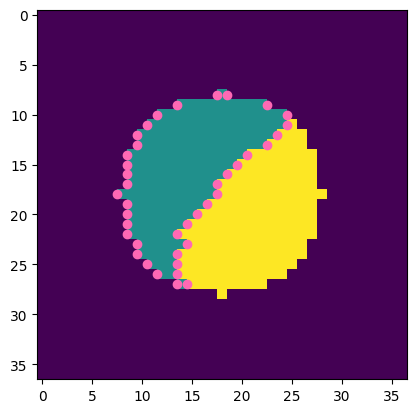

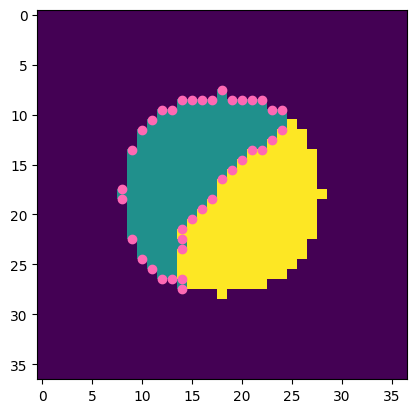

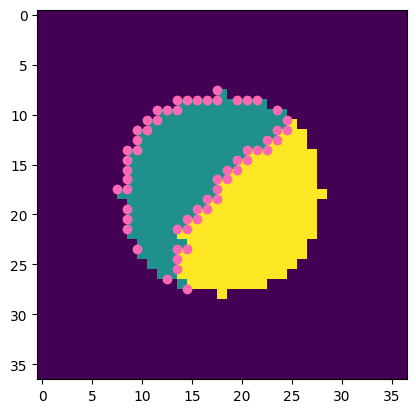

In [7]:

grad_x = np.abs(signal.convolve2d(object_clustered, horizontal_heaviside, mode='valid'))
grad_x=np.pad(grad_x, pad_width=[(0,0),(1,0)], mode='constant')
grad_y = np.abs(signal.convolve2d(object_clustered, vertical_heaviside, mode='valid'))
grad_y=np.pad(grad_y, pad_width=[(1,0),(0,0)], mode='constant')
grad_xy = np.abs(signal.convolve2d(object_clustered, diagonal_heaviside, mode='valid'))
grad_xy=np.pad(grad_xy, pad_width=[(1,0),(1,0)], mode='constant')

edge_pixels_x=np.where(grad_x==1)
edge_pixels_x=np.concatenate((edge_pixels_x[0].reshape(-1,1),edge_pixels_x[1].reshape(-1,1)-0.5),axis=1)
plt.figure()
plt.imshow(object_clustered)
plt.scatter(edge_pixels_x[:,1],edge_pixels_x[:,0],color = 'hotpink')
plt.show()

edge_pixels_y=np.where(grad_y==1)
edge_pixels_y=np.concatenate((edge_pixels_y[0].reshape(-1,1)-0.5,edge_pixels_y[1].reshape(-1,1)),axis=1)
plt.figure()
plt.imshow(object_clustered)
plt.scatter(edge_pixels_y[:,1],edge_pixels_y[:,0], color = 'hotpink')
plt.show()

edge_pixels_xy=np.where(grad_xy==1)
edge_pixels_xy=np.concatenate((edge_pixels_xy[0].reshape(-1,1)-0.5,edge_pixels_xy[1].reshape(-1,1)-0.5),axis=1)
plt.figure()
plt.imshow(object_clustered)
plt.scatter(edge_pixels_xy[:,1],edge_pixels_xy[:,0],color = 'hotpink')
plt.show()

# Try OpenCV contour from Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following. CVGIP 30 1, pp 32-46 (1985)

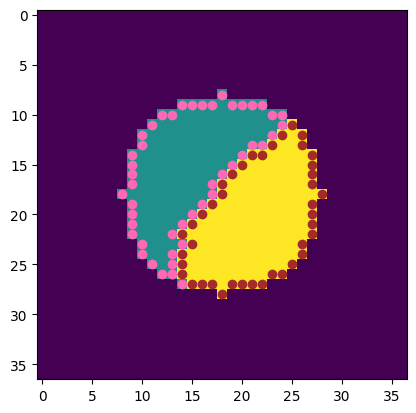

In [8]:
A=np.zeros_like(object_clustered_uint8)
A[object_clustered==1]=255
B=np.zeros_like(object_clustered_uint8)
B[object_clustered==2]=255
contours_A, _= cv.findContours(A, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
contours_B, _= cv.findContours(B, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

# select biggest contours
A_max=contours_A[0].size
i_max=0
for i in range(1,len(contours_A)):
    if contours_A[i].size>A_max:
        A_max=contours_A[i].size
        i_max=i
edge_pixels_A=np.squeeze(contours_A[i_max]).reshape((-1,2))

B_max=contours_B[0].size
i_max=0
for i in range(1,len(contours_B)):
    if contours_B[i].size>B_max:
        B_max=contours_B[i].size
        i_max=i
edge_pixels_B=np.squeeze(contours_B[i_max]).reshape((-1,2))

plt.figure()
plt.imshow(object_clustered)
plt.scatter(edge_pixels_A[:,0],edge_pixels_A[:,1], color = 'hotpink')
plt.scatter(edge_pixels_B[:,0],edge_pixels_B[:,1], color = 'brown')
plt.show()

# Filter Pixels that are on the cirle

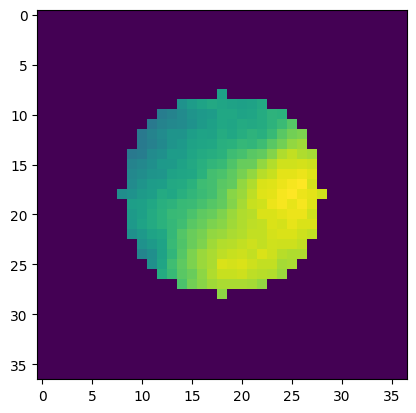

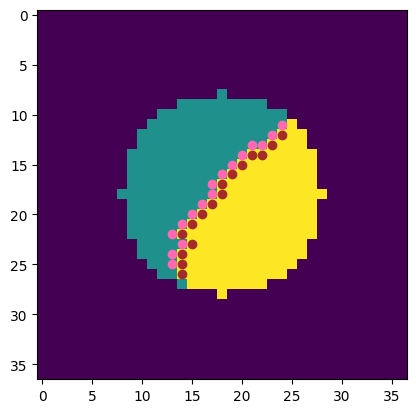

In [9]:
r_filter=cut_radius
center=np.array([obj_image_current.shape[1]//2,obj_image_current.shape[0]//2]).reshape((1,2))

index_A=edge_pixels_A-center
index_A_x=np.copy(index_A)
index_A_y=np.copy(index_A)
index_A_x[:,0]=np.abs(index_A[:,0])+1
index_A_x=np.sum((index_A_x)**2,axis=1)<=cut_radius**2
index_A_y[:,1]=np.abs(index_A[:,1])+1
index_A_y=np.sum((index_A_y)**2,axis=1)<=cut_radius**2
index_A=np.logical_and(index_A_x,index_A_y)

index_B=edge_pixels_B-center
index_B_x=np.copy(index_B)
index_B_y=np.copy(index_B)
index_B_x[:,0]=np.abs(index_B[:,0])+1
index_B_x=np.sum((index_B_x)**2,axis=1)<=cut_radius**2
index_B_y[:,1]=np.abs(index_B[:,1])+1
index_B_y=np.sum((index_B_y)**2,axis=1)<=cut_radius**2
index_B=np.logical_and(index_B_x,index_B_y)

edge_pixels_A=edge_pixels_A[index_A,:]
edge_pixels_B=edge_pixels_B[index_B,:]
plt.figure()
plt.imshow(obj_image_current)
plt.show()
plt.figure()
plt.imshow(object_clustered)
plt.scatter(edge_pixels_A[:,0],edge_pixels_A[:,1], color="hotpink")
plt.scatter(edge_pixels_B[:,0],edge_pixels_B[:,1], color="brown")
plt.show()


# Expand Edge Pixel into z dimension

In [10]:
# Edge Pixel in local coordinates
center_true=np.array([obj_0[index_number,1]-round(obj_0[index_number,1]-np.ceil(obj_0[index_number,3])),obj_0[index_number,2]-round(obj_0[index_number,2]-np.ceil(obj_0[index_number,3]))]).reshape((1,2))
radius_true=obj_0[index_number,-1]
edge_pixels_A_local=edge_pixels_A-center_true

z=-np.sqrt(radius_true**2-np.sum((edge_pixels_A_local)**2,axis=1)).reshape((-1,1))
edge_pixels_A_local=np.concatenate((edge_pixels_A_local,z),axis=1)

edge_pixels_B_local=edge_pixels_B-center_true
z=-np.sqrt(radius_true**2-np.sum((edge_pixels_B_local)**2,axis=1)).reshape((-1,1))
edge_pixels_B_local=np.concatenate((edge_pixels_B_local,z),axis=1)


# Fit Plane with PCA/SVD
#### First and Second Column Vector are basis vector of plane (points are spread out along theses coordinates)
#### Third column correspondents to normal vector of plana fit

In [11]:
edge_pixels_A_local=edge_pixels_A_local.T
centroid_pca_A=np.mean(edge_pixels_A_local, axis=1, keepdims=True)
svd_A = np.linalg.svd(edge_pixels_A_local - centroid_pca_A)

edge_pixels_B_local=edge_pixels_B_local.T
centroid_pca_B=np.mean(edge_pixels_B_local, axis=1, keepdims=True)
svd_B = np.linalg.svd(edge_pixels_B_local - centroid_pca_B)



# Extract the left singular vectors
left_A=svd_A[0]
right_A=svd_A[2]
left_B=svd_B[0]
right_B=svd_B[2]




In [12]:
n_pca_A=left_A[:,-1]
if n_pca_A[-1]<0:
    n_pca_A=-n_pca_A
n_pca_A=n_pca_A/np.linalg.norm(n_pca_A)
d_pca_A=np.sum(n_pca_A*centroid_pca_A.reshape((-1)))
error_pca_A=np.sum(edge_pixels_A_local*n_pca_A.reshape((3,1)),axis=0)-d_pca_A
error_pca_A=np.linalg.norm(error_pca_A)

n_pca_B=left_B[:,-1]
if n_pca_B[-1]<1:
    n_pca_B=-n_pca_B
n_pca_B=n_pca_B/np.linalg.norm(n_pca_B)
d_pca_B=np.sum(n_pca_B*centroid_pca_B.reshape((-1)))
error_pca_B=np.sum(edge_pixels_B_local*n_pca_B.reshape((3,1)),axis=0)-d_pca_B
error_pca_B=np.linalg.norm(error_pca_B)



# Fit Plane with Least Squares
#### Assume normal z component of normal vector is not close to zero

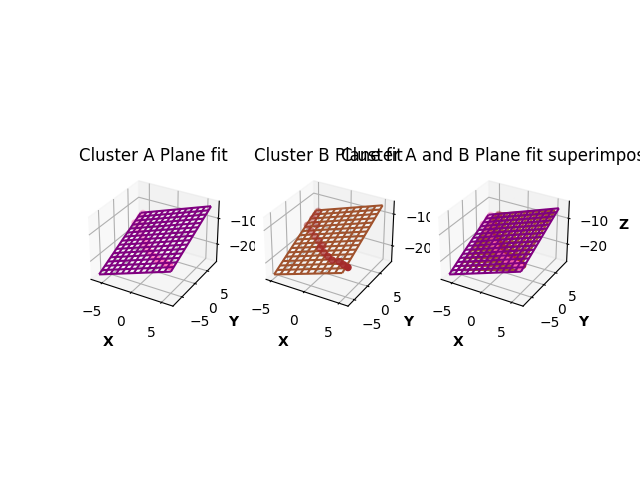

[-0.609 -0.532  0.589]
[-0.549 -0.487  0.679]
-8.980224711119423
-10.49926834801374
1.1551136304547218
1.2364204125902198
[ 0.563  0.487 -0.668]
[-0.517 -0.457  0.723]
10.994716007349185
-11.887700669790535
1.0831513574399558
1.1252518623024839


In [13]:
%matplotlib ipympl
plt.figure()
# For cluster A
ax = plt.subplot(131, projection='3d')
plt.title("Cluster A Plane fit")
ax.scatter(edge_pixels_A_local[0,:], edge_pixels_A_local[1,:], edge_pixels_A_local[2,:], color='hotpink')
tmp_A = []
tmp_b = []
for i in range(edge_pixels_A_local.shape[1]):
    tmp_A.append([edge_pixels_A_local[0,i], edge_pixels_A_local[1,i], 1])
    tmp_b.append(edge_pixels_A_local[2,i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit, residual, rnk, s = lstsq(A, b)
# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X_A,Y_A = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))

n_lq_A=np.vstack((-fit[:2,:],np.array([[1]]))).reshape((-1))
d_lq_A=fit[-1,0]/np.linalg.norm(n_lq_A)
n_lq_A=n_lq_A/np.linalg.norm(n_lq_A)
error_lq_A=np.sum(edge_pixels_A_local*n_lq_A.reshape((3,1)),axis=0)-d_lq_A
error_lq_A=np.linalg.norm(error_lq_A)

Z_A = np.zeros(X_A.shape)
for r in range(X_A.shape[0]):
    for c in range(X_A.shape[1]):
        Z_A[r,c] = (+d_lq_A-n_lq_A[0] * X_A[r,c] - n_lq_A[1] * Y_A[r,c])/(n_lq_A[2]) 
ax.plot_wireframe(X_A,Y_A,Z_A, color='purple')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

# For Cluster B
ax = plt.subplot(132, projection='3d')
plt.title("Cluster B Plane fit")
ax.scatter(edge_pixels_B_local[0,:], edge_pixels_B_local[1,:], edge_pixels_B_local[2,:], color='brown')
tmp_A = []
tmp_b = []
for i in range(edge_pixels_B_local.shape[1]):
    tmp_A.append([edge_pixels_B_local[0,i], edge_pixels_B_local[1,i], 1])
    tmp_b.append(edge_pixels_B_local[2,i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit, residual, rnk, s = lstsq(A, b)
# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X_B,Y_B = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))

n_lq_B=np.vstack((-fit[:2,:],np.array([[1]]))).reshape((-1))
d_lq_B=fit[-1,0]/np.linalg.norm(n_lq_B)
n_lq_B=n_lq_B/np.linalg.norm(n_lq_B)
error_lq_B=np.sum(edge_pixels_B_local*n_lq_B.reshape((3,1)),axis=0)-d_lq_B
error_lq_B=np.linalg.norm(error_lq_B)

Z_B = np.zeros(X_B.shape)
for r in range(X_B.shape[0]):
    for c in range(X_B.shape[1]):
        Z_B[r,c] = (+d_lq_B-n_lq_B[0] * X_B[r,c] - n_lq_B[1] * Y_B[r,c])/(n_lq_B[2]) 
ax.plot_wireframe(X_B,Y_B,Z_B, color='sienna')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

ax = plt.subplot(133, projection='3d')
plt.title("Cluster A and B Plane fit superimposed")
ax.scatter(edge_pixels_A_local[0,:], edge_pixels_A_local[1,:], edge_pixels_A_local[2,:], color='hotpink')
ax.scatter(edge_pixels_B_local[0,:], edge_pixels_B_local[1,:], edge_pixels_B_local[2,:], color='brown')
ax.plot_wireframe(X_A,Y_A,Z_A, color='purple')
ax.plot_wireframe(X_B,Y_B,Z_B, color='sienna')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

plt.show()



print(n_pca_A)
print(n_lq_A)
print(d_pca_A)
print(d_lq_A)
print(error_pca_A)
print(error_lq_A)

print(n_pca_B)
print(n_lq_B)
print(d_pca_B)
print(d_lq_B)
print(error_pca_B)
print(error_lq_B)


### Use all edge points of A and B to get plane fit!

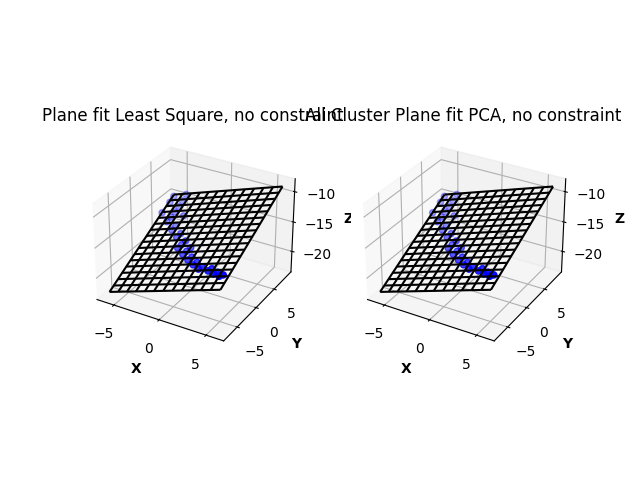

[-0.531 -0.466  0.708]
[-0.42  -0.387  0.821]
-11.30569439480573
-13.18891659552057
6.351815104001466
7.253445906446732


In [14]:
edge_pixels_local=np.concatenate((edge_pixels_A_local,edge_pixels_B_local),axis=1)
centroid_pca=np.mean(edge_pixels_local, axis=1, keepdims=True)
svd = np.linalg.svd(edge_pixels_local - centroid_pca)
n_pca= svd[0][:,-1]
d_pca=np.sum(n_pca*centroid_pca.reshape((-1)))
error_pca=np.sum(edge_pixels_local*n_pca.reshape((3,1)),axis=0)-d_pca
error_pca=np.linalg.norm(error_pca)**2

plt.figure()
ax = plt.subplot(121,projection='3d')
plt.title("Plane fit Least Square, no constraint")
ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
tmp_A = []
tmp_b = []
for i in range(edge_pixels_local.shape[1]):
    tmp_A.append([edge_pixels_local[0,i], edge_pixels_local[1,i], 1])
    tmp_b.append(edge_pixels_local[2,i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit, residual, rnk, s = lstsq(A, b)
# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))

n_lq=np.vstack((-fit[:2,:],np.array([[1]]))).reshape((-1))
d_lq=fit[-1,0]/np.linalg.norm(n_lq)
n_lq=n_lq/np.linalg.norm(n_lq)
error_lq=np.sum(edge_pixels_local*n_lq.reshape((3,1)),axis=0)-d_lq
error_lq=np.linalg.norm(error_lq)**2

Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = (+d_lq-n_lq[0] * X[r,c] - n_lq[1] * Y[r,c])/(n_lq[2]) 
ax.plot_wireframe(X,Y,Z, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

ax = plt.subplot(122,projection='3d')
plt.title("All Cluster Plane fit PCA, no constraint")
ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
tmp_A = []
tmp_b = []

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()



Z_pca = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z_pca[r,c] = (+d_pca-n_pca[0] * X[r,c] - n_pca[1] * Y[r,c])/(n_pca[2]) 
ax.plot_wireframe(X,Y,Z, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

plt.show()

print(n_pca)
print(n_lq)
print(d_pca)
print(d_lq)
print(error_pca)
print(error_lq)

# Fit Plane considering Origin as hard constraint
## For Least squares we need to solve min_w f(w)=w'*X'*X*w s.t w'*w=1

10.151624025523816
[[ 0.]
 [-0.]
 [ 0.]
 [ 0.]]
[-0.787 -0.617  0.02 ]


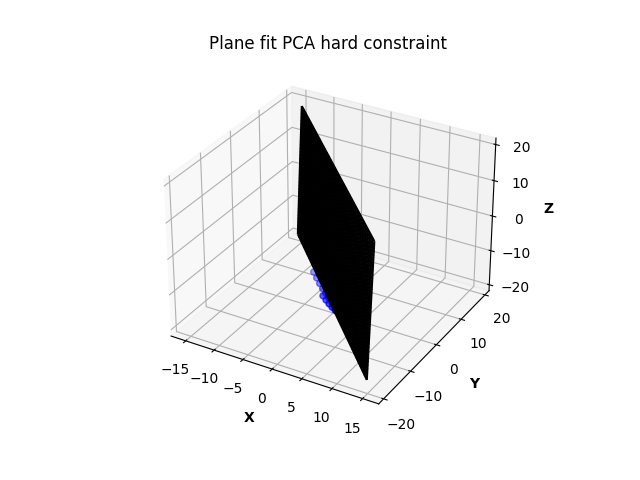

In [15]:
X=edge_pixels_local.T
A=np.matmul(edge_pixels_local,X)
f=lambda theta: 0.5*np.linalg.norm(np.matmul(X,theta[:3,:]))**2+theta[-1,0]*(np.linalg.norm(theta[:3,:])**2-1)
grad=lambda theta : np.vstack((np.matmul(A,theta[:3,:]) + theta[-1,0]*theta[:3,:],np.linalg.norm(theta[:3,:])**2-1))
Jacob=lambda theta : np.vstack((np.concatenate((theta[-1,0]*np.eye(3)+A,theta[:3,:]),axis=1),np.vstack((theta[:3,:],np.zeros((1,1)))).T))

svd = np.linalg.svd(edge_pixels_local)
theta_opt=svd[0][:,-1]
eig_value, eig_vectors = np.linalg.eig(A)
s_opt=svd[1][-1]
theta_opt=np.concatenate((theta_opt,np.array([-s_opt**2])),axis=0).reshape((-1,1))
n_opt_hard=theta_opt[:3,0]
print(f(theta_opt))
print(grad(theta_opt))
print(n_opt_hard)

plt.figure()
ax = plt.subplot(111,projection='3d')
plt.title("Plane fit PCA hard constraint")
ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
ax.scatter(0, 0, 0, color='r',s=10)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = np.array([-1+np.min(edge_pixels_local[2,:]), 1])
pivot=np.argmax(np.abs(n_opt_hard))

# plot plane
radius=np.int64(np.ceil(radius_true))+1
X1,X2 = np.meshgrid(np.arange(-radius,radius+1),
                  np.arange(-radius,radius+1))
if pivot==0:
    permutation=np.array([0,1,2])
elif pivot==1:
    permutation=np.array([1,0,2])
elif pivot==2:
    permutation=np.array([2,1,0])

n_permuted=n_opt_hard[permutation]

X_pivot = -(n_permuted[1] * X1 + n_permuted[2] * X2)/(n_permuted[0])

if pivot==0:
    X=X_pivot
    Y=X1
    Z=X2
elif pivot==1:
    X=X1
    Y=X_pivot
    Z=X2
else:
    X=X2
    Y=X1
    Z=X_pivot

ax.plot_wireframe(X,Y,Z, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

plt.show()


# Correct Indexing of plane

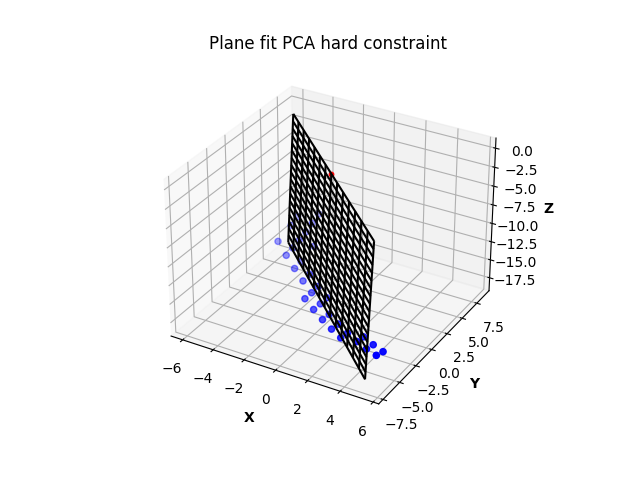

In [16]:
def indexing_plane(X,Y,Z,xlim,ylim,zlim):
    Index_x=np.logical_and(X>=xlim[0],X<=xlim[1])
    a=np.sum(Index_x,axis=1)
    a1=np.argmax(a>0)
    a2=a.shape[0]-np.argmax(a[::-1]>0)-1
    b=np.sum(Index_x,axis=0)
    b1=np.argmax(b>0)
    b2=b.shape[0]-np.argmax(b[::-1]>0)-1
    Index_x=np.array([a1,a2,b1,b2])
    Index_y=np.logical_and(Y>=ylim[0],Y<=ylim[1])
    a=np.sum(Index_y,axis=1)
    a1=np.argmax(a>0)
    a2=a.shape[0]-np.argmax(a[::-1]>0)-1
    b=np.sum(Index_y,axis=0)
    b1=np.argmax(b>0)
    b2=b.shape[0]-np.argmax(b[::-1]>0)-1
    Index_y=np.array([a1,a2,b1,b2])
    Index_z=np.logical_and(Z>=zlim[0],Z<=zlim[1])
    a=np.sum(Index_z,axis=1)
    a1=np.argmax(a>0)
    a2=a.shape[0]-np.argmax(a[::-1]>0)-1
    b=np.sum(Index_z,axis=0)
    b1=np.argmax(b>0)
    b2=b.shape[0]-np.argmax(b[::-1]>0)-1
    Index_z=np.array([a1,a2,b1,b2])
    Index=np.vstack((Index_x,Index_y,Index_z))
    Index=np.s_[np.max(Index[:,0]):np.min(Index[:,1]),np.max(Index[:,2]):np.min(Index[:,3])]
    return Index

Index=indexing_plane(X,Y,Z,xlim,ylim,zlim)
X_alt=X[Index]
Y_alt=Y[Index]
Z_alt=Z[Index]
plt.figure()
ax = plt.subplot(111,projection='3d')
plt.title("Plane fit PCA hard constraint")
ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
ax.scatter(0, 0, 0, color='r',s=10)
ax.plot_wireframe(X_alt,Y_alt,Z_alt, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')


plt.show()


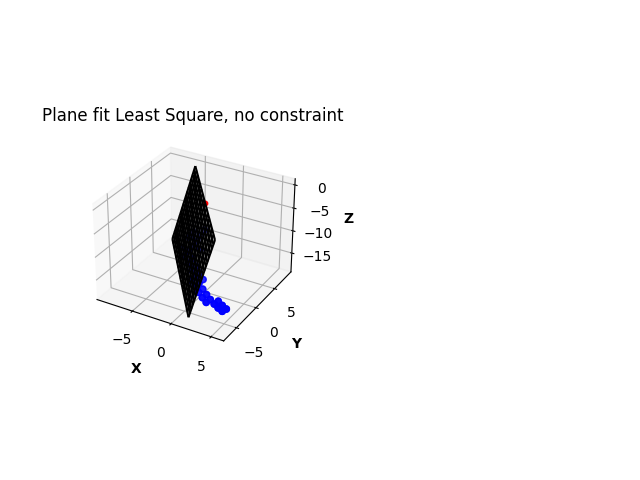

In [17]:
tmp_A = []
tmp_b = []
for i in range(edge_pixels_local.shape[1]):
    tmp_A.append([edge_pixels_local[0,i], edge_pixels_local[1,i]])
    tmp_b.append(edge_pixels_local[2,i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit, residual, rnk, s = lstsq(A, b)
n_ls_hard=np.vstack((-fit[:2,:],np.array([[1]]))).reshape((-1))
n_ls_hard=n_ls_hard/np.linalg.norm(n_ls_hard)
error_ls_hard=np.sum(edge_pixels_local*n_ls_hard.reshape((3,1)),axis=0)
error_ls_hard=np.linalg.norm(error_ls_hard)

plt.figure()
ax = plt.subplot(121,projection='3d')
plt.title("Plane fit Least Square, no constraint")
ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')

# plot plane

ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
ax.scatter(0, 0, 0, color='r',s=10)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = np.array([-1+np.min(edge_pixels_local[2,:]), 1])
n=n_ls_hard
pivot=np.argmax(np.abs(n))

# plot plane

radius=np.int64(np.ceil(radius_true))+1
X1,X2 = np.meshgrid(np.arange(-radius,radius+1),
                  np.arange(-radius,radius+1))
if pivot==0:
    permutation=np.array([0,1,2])
elif pivot==1:
    permutation=np.array([1,0,2])
elif pivot==2:
    permutation=np.array([2,1,0])
n_permuted=n[permutation]
X_pivot = -(n_permuted[1] * X1 + n_permuted[2] * X2)/(n_permuted[0])

if pivot==0:
    X=X_pivot
    Y=X1
    Z=X2
elif pivot==1:
    X=X1
    Y=X_pivot
    Z=X2
else:
    X=X2
    Y=X1
    Z=X_pivot

Index=indexing_plane(X,Y,Z,xlim,ylim,zlim)
X_alt=X[Index]
Y_alt=Y[Index]
Z_alt=Z[Index]
ax.plot_wireframe(X_alt,Y_alt,Z_alt, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

plt.show()


# Fit Plane considering Origin as soft constraint


In [18]:
X=edge_pixels_local.T
# additional penalty for deviation from origin increase
additional_penalty=X.shape[0]
mean_vector=np.sum(X, axis=0).reshape((1,-1))/(X.shape[0]+np.sqrt(additional_penalty))
svd = np.linalg.svd(X-mean_vector)
n_opt_soft=svd[-1][-1,:]
b_soft=-np.sum(mean_vector*n_opt_soft)

tmp_A = []
tmp_b = []
for i in range(edge_pixels_local.shape[1]):
    tmp_A.append([edge_pixels_local[0,i], edge_pixels_local[1,i], 1])
    tmp_b.append(edge_pixels_local[2,i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
A=np.vstack((A,np.array([0,0,np.sqrt(additional_penalty)]).reshape((1,-1))))
b=np.vstack((b,np.zeros(1)))
fit, residual, rnk, s = lstsq(A, b)
n_ls_soft=np.vstack((-fit[:2,:],np.array([[1]]))).reshape((-1))
b_ls_soft=-fit[-1,0]/np.linalg.norm(n_ls_soft)
n_ls_soft=n_ls_soft/np.linalg.norm(n_ls_soft)


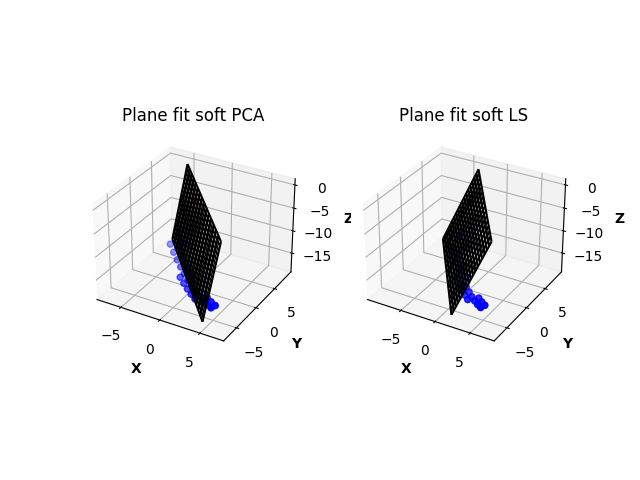

In [19]:
plt.figure()
ax = plt.subplot(121,projection='3d')
plt.title("Plane fit soft PCA")

ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
ax.scatter(0, 0, 0, color='r',s=10)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = np.array([-1+np.min(edge_pixels_local[2,:]), 1])
n=n_opt_soft
pivot=np.argmax(np.abs(n))

# plot plane
radius=np.int64(np.ceil(radius_true))+1
X1,X2 = np.meshgrid(np.arange(-radius,radius+1),
                  np.arange(-radius,radius+1))
if pivot==0:
    permutation=np.array([0,1,2])
elif pivot==1:
    permutation=np.array([1,0,2])
elif pivot==2:
    permutation=np.array([2,1,0])

n_permuted=n[permutation]
X_pivot = -(n_permuted[1] * X1 + n_permuted[2] * X2 + b_soft)/(n_permuted[0])

if pivot==0:
    X=X_pivot
    Y=X1
    Z=X2
elif pivot==1:
    X=X1
    Y=X_pivot
    Z=X2
else:
    X=X2
    Y=X1
    Z=X_pivot

Index=indexing_plane(X,Y,Z,xlim,ylim,zlim)
X_alt=X[Index]
Y_alt=Y[Index]
Z_alt=Z[Index]
ax.plot_wireframe(X_alt,Y_alt,Z_alt, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

ax = plt.subplot(122,projection='3d')
plt.title("Plane fit soft LS")

ax.scatter(edge_pixels_local[0,:], edge_pixels_local[1,:], edge_pixels_local[2,:], color='b')
ax.scatter(0, 0, 0, color='r',s=10)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = np.array([-1+np.min(edge_pixels_local[2,:]), 1])
n=n_ls_soft
pivot=np.argmax(np.abs(n))

# plot plane
radius=np.int64(np.ceil(radius_true))+1
X1,X2 = np.meshgrid(np.arange(-radius,radius+1),
                  np.arange(-radius,radius+1))
if pivot==0:
    permutation=np.array([0,1,2])
elif pivot==1:
    permutation=np.array([1,0,2])
elif pivot==2:
    permutation=np.array([2,1,0])

n_permuted=n[permutation]
X_pivot = -(n_permuted[1] * X1 + n_permuted[2] * X2 + b_ls_soft)/(n_permuted[0])

if pivot==0:
    X=X_pivot
    Y=X1
    Z=X2
elif pivot==1:
    X=X1
    Y=X_pivot
    Z=X2
else:
    X=X2
    Y=X1
    Z=X_pivot

Index=indexing_plane(X,Y,Z,xlim,ylim,zlim)
X_alt=X[Index]
Y_alt=Y[Index]
Z_alt=Z[Index]
ax.plot_wireframe(X_alt,Y_alt,Z_alt, color='k')
ax.set_xlabel('X', 
               fontweight ='bold')
ax.set_ylabel('Y', 
               fontweight ='bold')
ax.set_zlabel('Z', 
               fontweight ='bold')

plt.show()


# comparison between soft and hard constraint

In [20]:
error = lambda X, w: (np.linalg.norm(X@w.reshape(4,1)))**2/(X.shape[0])
X=np.concatenate((edge_pixels_local.T,np.ones((edge_pixels_local.shape[1],1))),axis=1)
print("not including origin as data point")
print("error soft constraint pca:",error(X,np.concatenate((n_opt_soft,b_soft*np.ones(1)))))
print("error ls soft constraint:",error(X,np.concatenate((n_ls_soft[:3],b_ls_soft*np.ones(1)))))
print("error hard constraint pca:",error(X,np.concatenate((n_opt_hard[:3],np.zeros(1)))))
print("error ls hard constraint:",error(X,np.concatenate((n_ls_hard[:3],np.zeros(1)))))
print("error pca no constraint:",error(X,np.concatenate((n_pca[:3],-d_pca*np.ones(1)))))
print("error ls no constraint:",error(X,np.concatenate((n_lq[:3],-d_lq*np.ones(1)))))



not including origin as data point
error soft constraint pca: 0.601506276228074
error ls soft constraint: 3.81202910568048
error hard constraint pca: 0.6344765015952385
error ls hard constraint: 4.664988516046998
error pca no constraint: 0.19849422200004588
error ls no constraint: 0.22667018457646046


# From normal Vector to valid rotation

In [21]:
# Transform Plane to sphere cartesian coordinate system, x goes to the right, y goes down, z into the screen. The origin lies in the middle of the sphere. Visble points on the surface thus have z component < 0.
n_reference=np.zeros(3)
n_reference[-1]=-1
n=np.copy(n_pca)
n[1:]=-n_pca[1:]
if n[-1]>0:
    # ensure that the normal vector n points outside the screen
    n=-n
axis_rot=np.cross(n_reference,n)
rotation_angle=np.arctan2(np.linalg.norm(axis_rot),np.dot(n_reference,n))
axis_rot=axis_rot/np.linalg.norm(axis_rot)
axis_rot=rotation_angle*axis_rot
Rotm=R.from_rotvec(axis_rot)


# Test Section

10
(37, 37)


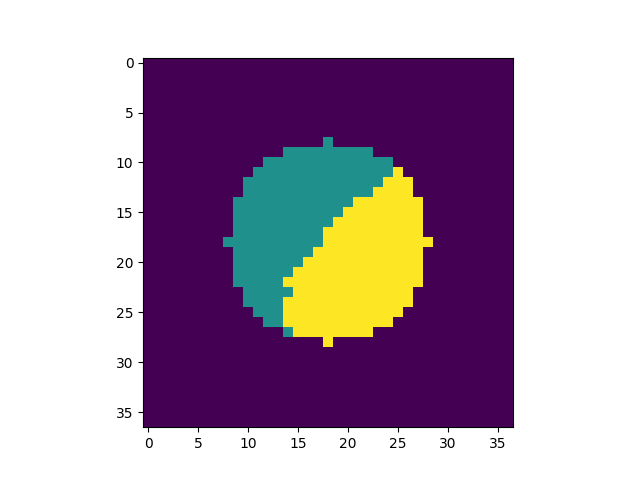

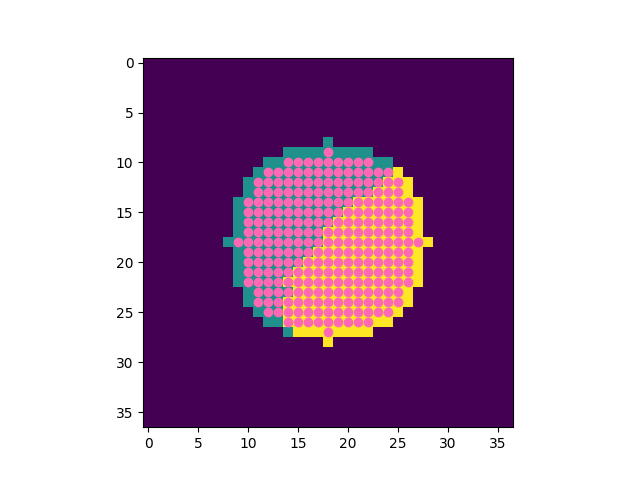

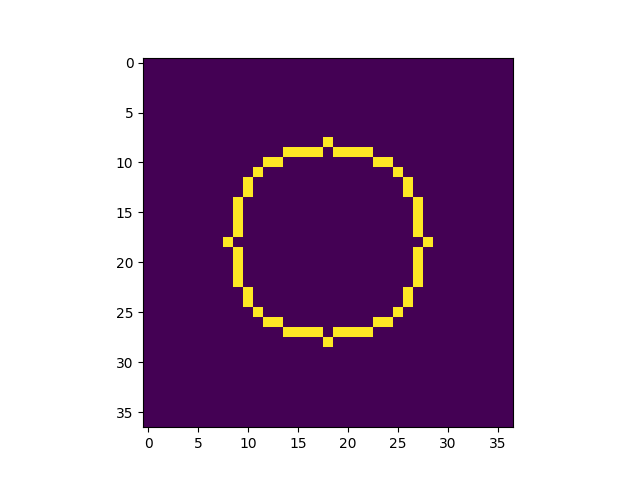

0


In [22]:
print(cut_radius)
print(object_clustered.shape)

plt.figure()
plt.imshow(object_clustered)
plt.show()

center=np.array([object_clustered.shape[1]//2,object_clustered.shape[0]//2]).reshape((1,2))
ring=np.copy(M)
x=np.arange(object_clustered.shape[0])
pixels = np.array(np.meshgrid(x, x)).T.reshape(-1, 2)
index=pixels-center
index_x=np.copy(index)
index_y=np.copy(index)
index_x[:,0]=np.abs(index[:,0])+1
index_x=np.sum((index_x)**2,axis=1)<=cut_radius**2
index_y[:,1]=np.abs(index[:,1])+1
index_y=np.sum((index_y)**2,axis=1)<=cut_radius**2
index=np.logical_and(index_x,index_y)
plt.figure()
plt.imshow(object_clustered)
pixels=pixels[index]
plt.scatter(pixels[:,0],pixels[:,1], color="hotpink")
plt.show()
ring[pixels[:,1],pixels[:,0]]=0
plt.figure()
plt.imshow(ring)
plt.show()
A=np.empty((0,2))
print(A.shape[0])

In [23]:

A=np.arange(9).reshape((3,3))
B=np.pad(A,pad_width=[(1,1),(1,1)], mode="edge")
print(A)
print(B)
c=np.logical_or(1, 0)
print(c.astype(int))

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 0 1 2 2]
 [0 0 1 2 2]
 [3 3 4 5 5]
 [6 6 7 8 8]
 [6 6 7 8 8]]
1
